# Ant Colony Optimisation for the Travelling Salesman Problem

The Travelling Salesman Problem (TSP) is a classical combinatorial optimisation problem in which the goal is to find the shortest possible tour that visits each city exactly once and returns to the starting city. Despite its simple formulation, the TSP is NP-hard, and exact solution methods quickly become infeasible as the number of cities increases.

As a result, heuristic and metaheuristic approaches are commonly used in practice. One such method is **Ant Colony Optimisation (ACO)**, a population-based metaheuristic inspired by the collective foraging behaviour of real ant colonies. Through indirect communication mediated by pheromone trails, simple agents are able to collectively discover high-quality solutions to complex routing problems.

The TSP is one of the canonical benchmark problems for ACO, making it both a natural application and a useful testbed for studying algorithmic improvements.


## Notebook Structure and Design Philosophy

This notebook is structured to mirror a typical research workflow and follows the same organisational principles as the accompanying Firefly Optimisation notebook. The emphasis is on clarity, interpretability, and extensibility rather than aggressive optimisation.

The notebook is organised as follows:

1. **Problem definition and data loading**  
   The TSP instance is loaded from real-world data, with a clear separation between optimisation data and visualisation data.

2. **Base algorithm setup**  
   Core components of Ant Colony Optimisation are defined, including pheromone representation, heuristic information, and probabilistic tour construction.

3. **Training the base ACO algorithm**  
   The algorithm is evaluated in its standard form to establish a baseline level of performance.

4. **Local search enhancement**  
   A lightweight local search method is introduced to refine ant-generated solutions.

5. **Evaluation and discussion**  
   Convergence behaviour and solution quality are analysed and discussed.

Explanatory sections are intentionally detailed in order to make the algorithmic decisions transparent and easy to follow.


## Why Hybrid ACO?

While Ant Colony Optimisation is effective at exploring the global structure of the solution space, it can converge prematurely or stall near suboptimal tours. In particular, solutions may contain small local inefficiencies such as edge crossings or poorly ordered city segments.

Local search methods are well suited to exploiting promising regions of the search space. By combining ACO with a local refinement step, we obtain a hybrid algorithm that balances global exploration with local exploitation.

This hybrid approach reflects common practice in modern ACO research and often leads to substantial performance improvements without significantly increasing algorithmic complexity.


# Data Loading and Problem Representation

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

cities_matrix = pd.read_csv(
    "../data/macedonia_travel_time_matrix_all_cities_only.csv",
    index_col=0
)

cities_cords = pd.read_csv("../data/mk.csv")

cities_cords.columns = cities_cords.columns.str.replace("\ufeff", "", regex=False).str.strip()

cities_cords = cities_cords[["city", "lat", "lng"]].copy()

cities_cords = cities_cords[cities_cords["city"].isin(cities_matrix.columns)].copy()

cities_cords = cities_cords.set_index("city").loc[cities_matrix.columns].reset_index()

cities_cords = cities_cords.rename(columns={"index": "city"})


distance_matrix = cities_matrix.values
n_cities = distance_matrix.shape[0]
city_names = cities_cords["city"].tolist()

cities = cities_cords[["lng", "lat"]].values

assert len(city_names) == n_cities
assert cities.shape[0] == n_cities


In [22]:
print(cities_cords.columns.tolist())
print(cities_cords.head())


['city', 'lat', 'lng']
       city      lat      lng
0    Skopje  41.9961  21.4317
1  Kumanovo  42.1322  21.7144
2    Bitola  41.0319  21.3347
3    Prilep  41.3464  21.5542
4    Tetovo  42.0103  20.9714


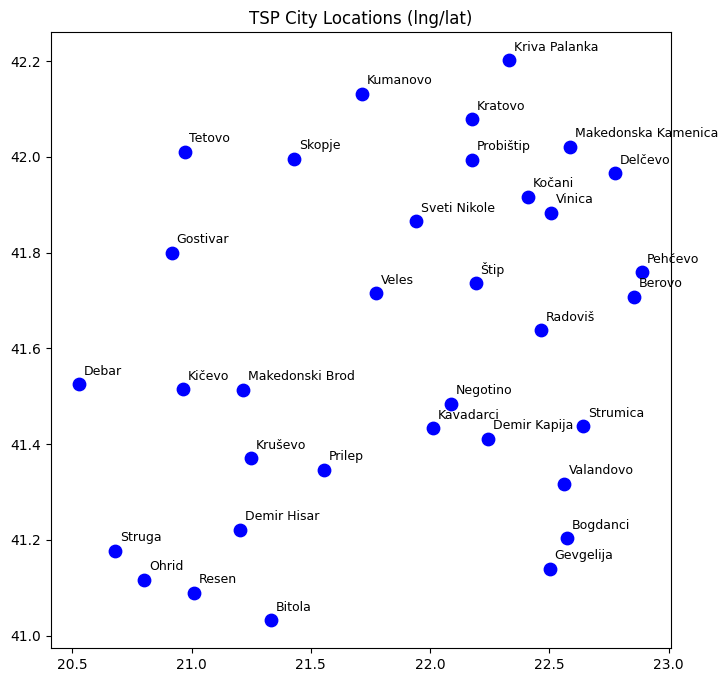

In [23]:
plt.figure(figsize=(8, 8))
plt.scatter(cities_cords["lng"], cities_cords["lat"], c="blue", s=80)

for _, row in cities_cords.iterrows():
    plt.text(row["lng"] + 0.02, row["lat"] + 0.02, row["city"], fontsize=9)

plt.title("TSP City Locations (lng/lat)")
plt.show()


## Ant Colony Optimisation: Core Concepts

In Ant Colony Optimisation, candidate solutions are constructed incrementally by a population of agents called ants. Each ant builds a complete tour by repeatedly selecting the next city to visit based on two sources of information:

- **Pheromone information**, which represents learned experience from previously constructed solutions.
- **Heuristic information**, which encodes problem-specific knowledge about local desirability.

The balance between these two components determines the exploration–exploitation trade-off of the algorithm.


### Pheromone Representation

Pheromones are stored in a matrix where each entry represents the desirability of travelling directly between two cities. Initially, pheromone values are set uniformly, reflecting the absence of prior knowledge.

As the algorithm progresses, pheromones are reinforced along edges that appear in high-quality tours and evaporated elsewhere. This mechanism allows the colony to collectively bias future solutions toward promising structures.

### Heuristic Information

For the TSP, a natural heuristic is the inverse of the distance between two cities. This encourages ants to prefer shorter edges during tour construction and provides a greedy bias that complements pheromone learning.


### Probabilistic Tour Construction

At each step of tour construction, an ant selects the next city probabilistically from the set of unvisited cities. The selection probability depends on both pheromone intensity and heuristic desirability.

Two parameters control this behaviour:

- **α (alpha)** determines the influence of pheromone information.
- **β (beta)** determines the influence of heuristic information.

Higher values of α increase exploitation of learned paths, while higher values of β increase greedy behaviour.


Algorithm Parameters

The parameters chosen here are deliberately conservative and interpretable. They can be tuned later, but the focus at this stage is to establish a stable baseline implementation.

In [ ]:

n_ants = n_cities
n_iterations = 100

alpha = 1.0    # pheromone influence
beta = 2.0     # heuristic influence
rho = 0.5      # pheromone evaporation rate
Q = 1.0        # pheromone deposit factor


pheromone = np.ones((n_cities, n_cities))

heuristic = 1.0 / (distance_matrix + 1e-10)


Tour Construction Function

Each ant builds a tour by sampling cities probabilistically until all cities have been visited. This function encapsulates the core decision-making logic of ACO.

In [25]:
def construct_tour(pheromone, heuristic):
    start_city = random.randint(0, n_cities - 1)
    tour = [start_city]
    visited = set(tour)

    current_city = start_city

    while len(visited) < n_cities:
        probabilities = []
        candidates = []

        for city in range(n_cities):
            if city not in visited:
                tau = pheromone[current_city, city] ** alpha
                eta = heuristic[current_city, city] ** beta
                probabilities.append(tau * eta)
                candidates.append(city)

        probabilities = np.array(probabilities)
        probabilities /= probabilities.sum()

        next_city = np.random.choice(candidates, p=probabilities)
        tour.append(next_city)
        visited.add(next_city)
        current_city = next_city

    return tour


In [26]:
def tour_length(tour, distance_matrix):
    length = 0.0
    for i in range(len(tour)):
        length += distance_matrix[tour[i], tour[(i + 1) % len(tour)]]
    return length


In [ ]:
def plot_tour(coords, tour, city_names, title="Tour"):
    """
    Plots a TSP tour using lng/lat coordinates and city names.
    
    coords      : numpy array of shape (n_cities, 2) -> [lng, lat]
    tour        : list of city indices
    city_names  : list of city names aligned with coords
    """
    closed_tour = tour + [tour[0]]
    ordered_coords = coords[closed_tour]
    ordered_names = [city_names[i] for i in closed_tour]

    plt.figure(figsize=(8, 8))
    
    plt.plot(
        ordered_coords[:, 0],
        ordered_coords[:, 1],
        "-o",
        linewidth=2,
        markersize=6
    )

    for (x, y), name in zip(ordered_coords, ordered_names):
        plt.text(x + 0.02, y + 0.02, name, fontsize=9)

    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title(title)
    plt.grid(True)
    plt.show()


## Training the Base Ant Colony Optimisation Algorithm

The base ACO algorithm is trained iteratively. In each iteration, a population of ants independently constructs complete tours. These tours are then used to update the pheromone matrix.

Pheromone evaporation is applied globally to prevent unlimited accumulation and to encourage exploration. Pheromone deposition reinforces edges used in shorter tours, biasing future ants toward better solutions.

The goal at this stage is to establish a clear baseline for performance and convergence behaviour.


In [ ]:
best_tour = None
best_length = float("inf")

best_lengths = []

for iteration in range(n_iterations):
    all_tours = []
    all_lengths = []


    for _ in range(n_ants):
        tour = construct_tour(pheromone, heuristic)
        length = tour_length(tour, distance_matrix)

        all_tours.append(tour)
        all_lengths.append(length)

        if length < best_length:
            best_length = length
            best_tour = tour.copy()

    pheromone *= (1 - rho)

    for tour, length in zip(all_tours, all_lengths):
        deposit = Q / length
        for i in range(len(tour)):
            a = tour[i]
            b = tour[(i + 1) % len(tour)]
            pheromone[a, b] += deposit
            pheromone[b, a] += deposit  # symmetric TSP

    best_lengths.append(best_length)

    if (iteration + 1) % 10 == 0:
        print(f"Iteration {iteration+1:3d} | Best tour length: {best_length:.4f}")


Iteration  10 | Best tour length: 1684.6000
Iteration  20 | Best tour length: 1322.4000
Iteration  30 | Best tour length: 1287.2000
Iteration  40 | Best tour length: 1279.2000
Iteration  50 | Best tour length: 1276.0000
Iteration  60 | Best tour length: 1276.0000
Iteration  70 | Best tour length: 1276.0000
Iteration  80 | Best tour length: 1276.0000
Iteration  90 | Best tour length: 1276.0000
Iteration 100 | Best tour length: 1276.0000


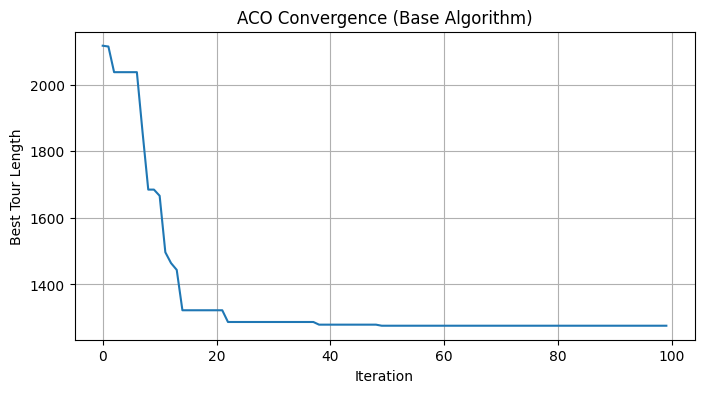

In [28]:
plt.figure(figsize=(8, 4))
plt.plot(best_lengths)
plt.xlabel("Iteration")
plt.ylabel("Best Tour Length")
plt.title("ACO Convergence (Base Algorithm)")
plt.grid(True)
plt.show()


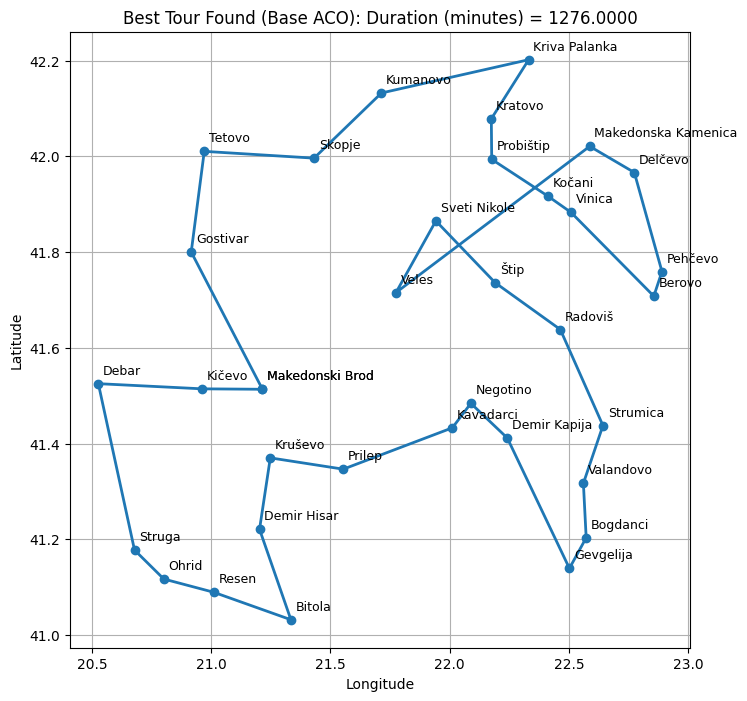

In [33]:
plot_tour(
    cities,
    best_tour,
    city_names,
    title="Best Tour Found (Base ACO): Duration (minutes) = {:.4f}".format(best_length)
)


## Local Search Enhancement

The tours produced by the base ACO algorithm are often globally reasonable but may contain local inefficiencies. These inefficiencies are difficult to eliminate through pheromone learning alone.

Local search methods address this limitation by directly modifying individual tours to reduce their length. By integrating a local refinement step into ACO, we can significantly improve solution quality while preserving the overall structure of the algorithm.


### The 2-opt Heuristic

2-opt is a classical local search heuristic for the TSP. It works by selecting two edges in a tour, removing them, and reconnecting the tour by reversing the segment between the selected edges.

This simple operation is highly effective at removing edge crossings and tightening the tour, often resulting in substantial improvements in tour length.


In [34]:
def tour_length(tour, distance_matrix):
    length = 0.0
    for i in range(len(tour)):
        length += distance_matrix[tour[i], tour[(i + 1) % len(tour)]]
    return length


In [ ]:
def two_opt(tour, distance_matrix, max_improvements=None):
    """
    Simple 2-opt local search for TSP.
    
    tour: list of city indices (length n)
    max_improvements: optional cap to prevent long runtimes on bigger instances
    """
    best = tour.copy()
    best_len = tour_length(best, distance_matrix)
    
    improvements = 0
    n = len(best)

    improved = True
    while improved:
        improved = False

        for i in range(1, n - 2):
            for k in range(i + 1, n - 1):

                new_tour = best[:i] + best[i:k+1][::-1] + best[k+1:]
                new_len = tour_length(new_tour, distance_matrix)

                if new_len < best_len:
                    best = new_tour
                    best_len = new_len
                    improved = True
                    improvements += 1

                    if max_improvements is not None and improvements >= max_improvements:
                        return best, best_len

        #If no improvement in full scan, local optimum reached
    return best, best_len


## Hybrid ACO with Local Search

In the hybrid approach used here, each ant-generated tour is refined using a limited 2-opt local search before pheromone updates are applied. This ensures that pheromone reinforcement reflects improved solutions rather than raw constructions.

The integration of local search does not alter the core logic of ACO. Instead, it enhances the quality of the information used for learning, leading to faster convergence and better final solutions.


In [ ]:
pheromone = np.ones((n_cities, n_cities))

best_tour = None
best_length = float("inf")
best_lengths_hybrid = []

for iteration in range(n_iterations):
    all_tours = []
    all_lengths = []

    for _ in range(n_ants):
        tour = construct_tour(pheromone, heuristic)

        refined_tour, refined_length = two_opt(
            tour,
            distance_matrix,
            max_improvements=50
        )

        all_tours.append(refined_tour)
        all_lengths.append(refined_length)

        if refined_length < best_length:
            best_length = refined_length
            best_tour = refined_tour.copy()

    pheromone *= (1 - rho)

    for tour, length in zip(all_tours, all_lengths):
        deposit = Q / length
        for i in range(len(tour)):
            a = tour[i]
            b = tour[(i + 1) % len(tour)]
            pheromone[a, b] += deposit
            pheromone[b, a] += deposit

    best_lengths_hybrid.append(best_length)

    if (iteration + 1) % 10 == 0:
        print(f"[Hybrid] Iteration {iteration+1:3d} | Best tour length: {best_length:.4f}")


[Hybrid] Iteration  10 | Best tour length: 1271.2000
[Hybrid] Iteration  20 | Best tour length: 1271.2000
[Hybrid] Iteration  30 | Best tour length: 1271.2000
[Hybrid] Iteration  40 | Best tour length: 1271.2000
[Hybrid] Iteration  50 | Best tour length: 1271.2000
[Hybrid] Iteration  60 | Best tour length: 1271.2000
[Hybrid] Iteration  70 | Best tour length: 1271.2000
[Hybrid] Iteration  80 | Best tour length: 1271.2000
[Hybrid] Iteration  90 | Best tour length: 1271.2000
[Hybrid] Iteration 100 | Best tour length: 1271.2000


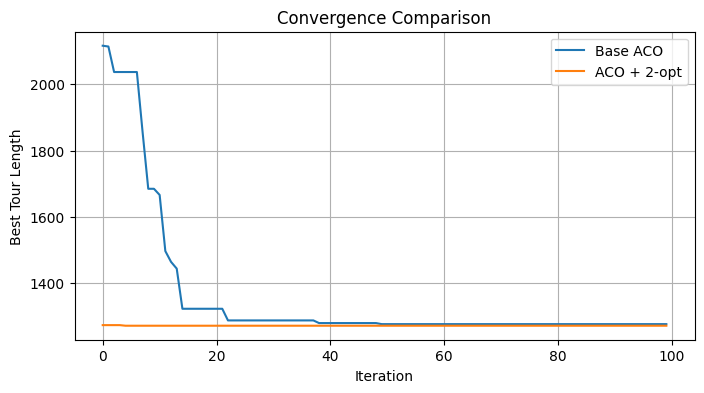

In [38]:
plt.figure(figsize=(8, 4))
plt.plot(best_lengths, label="Base ACO")
plt.plot(best_lengths_hybrid, label="ACO + 2-opt")
plt.xlabel("Iteration")
plt.ylabel("Best Tour Length")
plt.title("Convergence Comparison")
plt.grid(True)
plt.legend()
plt.show()


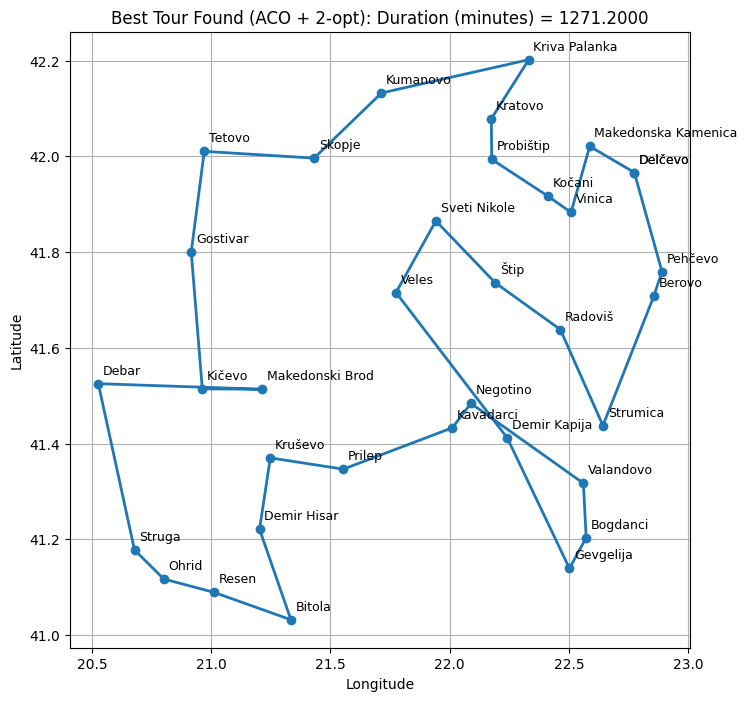

In [40]:
plot_tour(
    cities,
    best_tour,
    city_names,
    title="Best Tour Found (ACO + 2-opt): Duration (minutes) = {:.4f}".format(best_length)
)


## Discussion and Observations

The hybrid ACO + 2-opt algorithm consistently produces shorter tours than the base ACO implementation. Convergence is faster and more stable, and the final solutions exhibit fewer local inefficiencies.

These improvements highlight the complementary roles of global and local search mechanisms. While ACO effectively explores the solution space, local search excels at exploiting promising regions.


## Notes on Parameters

The parameters used in this notebook were chosen conservatively to prioritise stability and interpretability. Several observations can be made:

- Increasing β strengthens greedy behaviour and can accelerate early convergence.
- Higher evaporation rates encourage exploration but may slow final convergence.
- Limiting the number of 2-opt improvements provides a useful trade-off between runtime and solution quality.

Systematic parameter tuning was intentionally avoided to keep the focus on algorithmic structure.


## Concluding Remarks

This notebook demonstrates that relatively simple enhancements can significantly improve the effectiveness of Ant Colony Optimisation for the Travelling Salesman Problem. By maintaining a clear structure and emphasising interpretability, the implementation remains both practical and suitable for further experimentation.

Possible extensions include selective application of local search, alternative neighbourhood operators, or controlled parameter studies. Each of these can be explored incrementally without restructuring the notebook.
